# **Librerías**

In [50]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Machine Learning
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib 

# Time series y estadísticas
from tsxv.splitTrainValTest import split_train_val_test_groupKFold
from statsmodels.tsa.stattools import bds
from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# **Carga de datos**

In [51]:
data = pd.read_csv('../data/btc_final.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# **Modelado**

In [52]:
def modelado_volatilidad_univariado(data, lags_list, volatilidad_target=7, n_steps_forecast=7, n_steps_jump=1):
    """
    Entrena modelos MLP univariados (Volatilidad -> Volatilidad) y guarda el mejor fold de cada lag como artefacto MLOps.
    """
    all_results_list = []
    dictresultados = {}
    modelos_por_lag = {}
    escaladores_por_lag = {}

    print(f"\n{'='*60}")
    print(f"ENTRENANDO MODELOS UNIVARIADOS - VOLATILIDAD {volatilidad_target} DÍAS")
    print(f"{'='*60}")

    for n_steps_input in lags_list:
        print(f"\n--- Procesando Lag {n_steps_input} días ---")
        time_series_univariada = data[f'Volatilidad_{volatilidad_target}d'].dropna()

        X, y, Xcv, ycv, Xtest, ytest = split_train_val_test_groupKFold(
            time_series_univariada,
            n_steps_input,
            n_steps_forecast,
            n_steps_jump
        )

        preds_train_folds, preds_val_folds, preds_test_folds = [], [], []
        real_train_folds, real_val_folds, real_test_folds = [], [], []
        bds_pvalues_folds = []
        modelos_folds = []
        escaladores_folds = []

        for fold in range(len(X)):
            print(f"    Fold {fold+1}/{len(X)}")

            scaler_x = RobustScaler().fit(X[fold])
            y_train_log = np.log1p(y[fold])
            scaler_y = StandardScaler().fit(y_train_log)

            X_train_scaled = scaler_x.transform(X[fold])
            X_val_scaled = scaler_x.transform(Xcv[fold])
            X_test_scaled = scaler_x.transform(Xtest[fold])
            y_train_scaled = scaler_y.transform(y_train_log)

            model = MLPRegressor(
                hidden_layer_sizes=(128, 64),
                activation="relu",
                solver="adam",
                alpha=1e-3,
                early_stopping=False,
                max_iter=2000,
                random_state=fold,
                learning_rate_init=5e-4
            )
            model.fit(X_train_scaled, y_train_scaled)

            modelos_folds.append(model)
            escaladores_folds.append((scaler_x, scaler_y))

            # Predicciones en log-space → inversa → expm1
            preds_test_log = model.predict(X_test_scaled)
            preds_test_des_log = scaler_y.inverse_transform(preds_test_log)
            preds_test_des = np.expm1(preds_test_des_log)
            y_test_des = ytest[fold]

            residuos_h1 = y_test_des[:, 0] - preds_test_des[:, 0]
            try:
                _, bds_pvalue = bds(residuos_h1, max_dim=2)
                bds_pvalue = bds_pvalue if not np.isnan(bds_pvalue) else np.nan
            except Exception:
                bds_pvalue = np.nan
            bds_pvalues_folds.append(bds_pvalue)

            for h in range(n_steps_forecast):
                y_true = y_test_des[:, h]
                y_pred = preds_test_des[:, h]
                epsilon = 1e-8
                mape_val = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
                mae_val = mean_absolute_error(y_true, y_pred)
                mse_val = mean_squared_error(y_true, y_pred)
                rmse_val = np.sqrt(mse_val)

                weight = 1.0 if h == 0 else 0.5
                weighted_rmse = rmse_val * weight

                all_results_list.append({
                    "n_steps_input": n_steps_input, "fold": fold + 1,
                    "horizon": h + 1, "MAPE": mape_val, "MAE": mae_val,
                    "RMSE": rmse_val, "MSE": mse_val,
                    "weighted_rmse": weighted_rmse,
                    "BDS_pvalue": bds_pvalue if h == 0 else np.nan
                })

            # Guardar preds/reales
            preds_train_log = model.predict(X_train_scaled)
            preds_val_log = model.predict(X_val_scaled)

            preds_train_folds.append(np.expm1(scaler_y.inverse_transform(preds_train_log)))
            preds_val_folds.append(np.expm1(scaler_y.inverse_transform(preds_val_log)))
            preds_test_folds.append(preds_test_des)
            real_train_folds.append(y[fold])
            real_val_folds.append(ycv[fold])
            real_test_folds.append(y_test_des)

        dictresultados[n_steps_input] = {
            "reals": {"train": real_train_folds, "val": real_val_folds, "test": real_test_folds},
            "preds": {"train": preds_train_folds, "val": preds_val_folds, "test": preds_test_folds},
            "original_df": data,
            "bds_pvalues": bds_pvalues_folds
        }

        modelos_por_lag[n_steps_input] = modelos_folds
        escaladores_por_lag[n_steps_input] = escaladores_folds

        lag_df = pd.DataFrame([r for r in all_results_list if r["n_steps_input"] == n_steps_input])
        fold_metrics = lag_df.groupby('fold').agg({
            'weighted_rmse': 'mean',
            'RMSE': 'mean',
            'MAPE': 'mean',
            'MAE': 'mean',
            'MSE': 'mean',
            'BDS_pvalue': 'first'
        }).reset_index()
        best_fold = int(fold_metrics.loc[fold_metrics['weighted_rmse'].idxmin(), 'fold']) - 1
        best_row = fold_metrics.loc[fold_metrics['weighted_rmse'].idxmin()]

        print(f" Mejor fold para lag {n_steps_input}: Fold {best_fold+1} | RMSE: {best_row['RMSE']:.4f}")

        model = modelos_folds[best_fold]
        scaler_x, scaler_y = escaladores_folds[best_fold]

        assert scaler_x.n_features_in_ == n_steps_input, "❌ El lag no coincide con el escalador"

        model_info = {
            "lag": n_steps_input,
            "fold": best_fold + 1,
            "RMSE": best_row['RMSE'],
            "MAPE": best_row['MAPE'],
            "MAE": best_row['MAE'],
            "MSE": best_row['MSE'],
            "BDS_pvalue": best_row['BDS_pvalue'],
            "reals": dictresultados[n_steps_input]["reals"]["test"][best_fold],
            "preds": dictresultados[n_steps_input]["preds"]["test"][best_fold]
        }

        artifacts = {
            "model": model,
            "scaler_x": scaler_x,
            "scaler_y": scaler_y,
            "info": model_info
        }

        joblib.dump(artifacts, f"../app/model_lag{n_steps_input}.joblib")

    results_df = pd.DataFrame(all_results_list)
    print(f"\n✓ Proceso de modelado finalizado. Se guardaron {len(lags_list)} modelos.")

    return {
        'results_all': dictresultados,
        'results_df': results_df
    }


## Flujo del Proceso

### 1. Experimentación con Ventanas Temporales (Lags)
- Se prueban múltiples ventanas (`lags_list = [7, 14, 21, 28]`).
- Cada modelo aprende con distinta "memoria" de datos históricos para encontrar el lag óptimo.

### 2. Validación Cruzada con Series Temporales
- Se utiliza **GroupKFold** mediante `split_train_val_test_groupKFold`.
- Beneficios:
  - Evita *data leakage* (simula entorno real de predicción).
  - Mayor robustez: múltiples folds → métricas más fiables.

### 3. Preprocesamiento y Escalado por Fold
- **X (features)**: `RobustScaler`, menos sensible a outliers financieros.
- **y (target)**:
  - `np.log1p(y)`: estabiliza varianza y reduce asimetría.
  - `StandardScaler`: normaliza tras la transformación.
- Escaladores ajustados únicamente con datos de entrenamiento (sin fuga de información).

### 4. Entrenamiento del MLP
- Arquitectura: `MLPRegressor(hidden_layer_sizes=(128, 64), activation="relu")`
- Parámetros clave:
  - `alpha=1e-3`: regularización L2 (previene sobreajuste).
  - `random_state=fold`: reproducibilidad.
  - `learning_rate_init`: controla la convergencia.

### 5. Evaluación y Selección
- **Predicción y desescalado**: uso de `inverse_transform` + `np.expm1`.
- **Métricas calculadas**: `MAPE`, `MAE`, `RMSE`, `MSE` para horizontes de 1 a 7 días.
- **Selección del mejor fold**:
  - Basado en `weighted_rmse` (prioriza precisión en corto plazo).
  - No se promedian folds → se guarda el mejor.

### 6. Artefactos de MLOps
- Cada modelo final (mejor fold) se guarda con:
  - `model` (MLP entrenado).
  - `scaler_x` y `scaler_y` (ajustados).
  - `info` con métricas de rendimiento.
- Guardado vía `joblib.dump()`, garantizando consistencia en despliegue.

---

## Validación y Afinado con Pytest

### Pruebas de Control de Calidad
1. **`test_model_rmse_threshold()`**  
   - Valida RMSE en un dataset fijo (`TEST_INPUTS`).  
   - Aserción: `rmse < RMSE_TOLERANCES[lag]`.  
   - Garantiza rendimiento mínimo y estable.

2. **`test_model_residuals_are_stable()`**  
   - Evalúa el error máximo absoluto en horizontes de predicción.  
   - Aserción: `max_residual < RESIDUAL_TOLERANCES[lag]`.  
   - Garantiza robustez y evita outliers de predicción.

### Afinado Iterativo
- Ajuste de hiperparámetros (`alpha`, `learning_rate`, arquitectura).
- Reentrenamiento y revalidación con pruebas automatizadas.
- Iteración hasta cumplir tolerancias de **rendimiento** y **estabilidad**.


In [53]:
def resumen_metricas(results_df):
    """
    Genera y guarda tablas resumen de las métricas del experimento,
    incluyendo diagnóstico BDS por horizonte y comparativas por lag.
    Todas las tablas se guardan en la carpeta 'results'.
    """

    results_path = 'results'
    os.makedirs(results_path, exist_ok=True)

    # 1. Métricas por horizonte y tamaño de input
    resumen_metricas = (
        results_df
        .groupby(['n_steps_input', 'horizon'])[['MAPE', 'MAE', 'RMSE', 'MSE']]
        .agg(['mean', 'std'])
        .round(3)
    )

    # 2. Diagnóstico BDS original (solo horizonte 1, desde results_df)
    df_bds = results_df[results_df['horizon'] == 1]
    resumen_bds = (
        df_bds
        .groupby('n_steps_input')['BDS_pvalue']
        .agg(['mean', 'std'])
        .round(3)
    )

    # 3. Comparativa por lag (la que estaba en visualizar_experimento)
    resumen_input = (
        results_df
        .groupby('n_steps_input')[['MAPE', 'MAE', 'RMSE', 'MSE']]
        .agg(['mean', 'std'])
        .round(4)
    )
    resumen_bds2 = (
        df_bds
        .groupby('n_steps_input')['BDS_pvalue']
        .agg(['mean', 'std'])
        .round(4)
    )
    reporte_final = resumen_input.copy()
    reporte_final[('BDS_pvalue', 'mean')] = resumen_bds2['mean']
    reporte_final[('BDS_pvalue', 'std')] = resumen_bds2['std']

    # Mostrar en notebook/terminal
    print("\n📊 Métricas por tamaño de input y horizonte:")
    display(resumen_metricas)

    print("\n📊 Diagnóstico BDS por ventana (horizonte 1) [desde results_df]:")
    display(resumen_bds)

    print("\n📊 Tabla Resumen Comparativa por Lag:")
    display(reporte_final)

    # Guardar tablas
    resumen_metricas.to_csv(os.path.join(results_path, 'resumen_metricas_por_horizonte.csv'))
    resumen_bds.to_csv(os.path.join(results_path, 'diagnostico_bds.csv'))
    reporte_final.to_csv(os.path.join(results_path, 'reporte_resumen_lags.csv'))

    print(f"\n✓ Tablas guardadas en: {results_path}")


In [54]:
def resumen_metricas(results_df):
    """
    Genera y guarda tablas resumen de las métricas del experimento,
    incluyendo diagnóstico BDS por horizonte y comparativas por lag.
    Todas las tablas se guardan en la carpeta 'results'.
    """

    results_path = 'results'
    os.makedirs(results_path, exist_ok=True)

    # 1. Métricas por horizonte y tamaño de input
    resumen_metricas = (
        results_df
        .groupby(['n_steps_input', 'horizon'])[['MAPE', 'MAE', 'RMSE', 'MSE']]
        .agg(['mean', 'std'])
        .round(3)
    )

    # 2. Diagnóstico BDS original (solo horizonte 1, desde results_df)
    df_bds = results_df[results_df['horizon'] == 1]
    resumen_bds = (
        df_bds
        .groupby('n_steps_input')['BDS_pvalue']
        .agg(['mean', 'std'])
        .round(3)
    )

    # 3. Comparativa por lag (la que estaba en visualizar_experimento)
    resumen_input = (
        results_df
        .groupby('n_steps_input')[['MAPE', 'MAE', 'RMSE', 'MSE']]
        .agg(['mean', 'std'])
        .round(4)
    )
    resumen_bds2 = (
        df_bds
        .groupby('n_steps_input')['BDS_pvalue']
        .agg(['mean', 'std'])
        .round(4)
    )
    reporte_final = resumen_input.copy()
    reporte_final[('BDS_pvalue', 'mean')] = resumen_bds2['mean']
    reporte_final[('BDS_pvalue', 'std')] = resumen_bds2['std']

    # Mostrar en notebook/terminal
    print("\n📊 Métricas por tamaño de input y horizonte:")
    display(resumen_metricas)

    print("\n📊 Diagnóstico BDS por ventana (horizonte 1) [desde results_df]:")
    display(resumen_bds)

    print("\n📊 Tabla Resumen Comparativa por Lag:")
    display(reporte_final)

    # Guardar tablas
    resumen_metricas.to_csv(os.path.join(results_path, 'resumen_metricas_por_horizonte.csv'))
    resumen_bds.to_csv(os.path.join(results_path, 'diagnostico_bds.csv'))
    reporte_final.to_csv(os.path.join(results_path, 'reporte_resumen_lags.csv'))

    print(f"\n✓ Tablas guardadas en: {results_path}")


def visualizar_experimento(results_all, results_df, lags_list, n_steps_forecast):
    """
    Genera, muestra y guarda todas las visualizaciones del experimento
    (series temporales y resúmenes gráficos de RMSE).
    """

    print("Iniciando la generación de visualizaciones...")

    # Rutas de guardado
    figs_path = os.path.join('notebooks', 'figs')
    os.makedirs(figs_path, exist_ok=True)

    # Paleta de colores para consistencia
    colors = ["#D5C8EF", '#9370DB', '#6a0dad', "#4B0082"]

    # ========================================================================
    # 1. GRÁFICAS DE SERIES TEMPORALES (TRAIN/VAL/TEST)
    # ========================================================================
    print("\n--- Generando Gráficas de Series Temporales Completas ---")
    
    for lag in lags_list:
        results = results_all[lag]
        df_lag = results_df[results_df['n_steps_input'] == lag]
        mean_rmse_per_fold = df_lag.groupby('fold')['RMSE'].mean().sort_values()

        # Seleccionar folds representativos
        best_fold_idx = mean_rmse_per_fold.index[0] - 1
        worst_fold_idx = mean_rmse_per_fold.index[-1] - 1
        median_fold_idx = mean_rmse_per_fold.index[len(mean_rmse_per_fold) // 2] - 1

        folds_to_plot = {
            f'Mejor Fold (Fold {best_fold_idx + 1})': best_fold_idx,
            f'Fold Mediano (Fold {median_fold_idx + 1})': median_fold_idx,
            f'Peor Fold (Fold {worst_fold_idx + 1})': worst_fold_idx,
        }

        print(f"\n📈 Visualizando para ventana de {lag} días...")
        for name, idx in folds_to_plot.items():
            # Extraer datos de reales y predicciones para el fold `idx`
            real_train = results['reals']['train'][idx][:, 0]
            pred_train = results['preds']['train'][idx][:, 0]
            real_val = results['reals']['val'][idx][:, 0]
            pred_val = results['preds']['val'][idx][:, 0]
            real_test = results['reals']['test'][idx][:, 0]
            pred_test = results['preds']['test'][idx][:, 0]

            original_df = results['original_df']
            n_folds = len(results['reals']['test'])
            
            # Reconstruir índices de tiempo
            test_end_idx = len(original_df) - (n_folds - 1 - idx) * len(real_test)
            test_start_idx = test_end_idx - len(real_test)
            val_end_idx = test_start_idx
            val_start_idx = val_end_idx - len(real_val)
            train_end_idx = val_start_idx
            train_start_idx = train_end_idx - len(real_train)
            
            train_ts = original_df.index[max(0, train_start_idx):train_end_idx]
            val_ts = original_df.index[val_start_idx:val_end_idx]
            test_ts = original_df.index[test_start_idx:test_end_idx]
            
            # Graficar
            plt.figure(figsize=(18, 6))
            plt.title(f'{name} - Input {lag} días - Horizonte 1', fontsize=16)

            # Eje x con años
            import matplotlib.dates as mdates
            ax = plt.gca()
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            plt.gcf().autofmt_xdate()

            # Train
            plt.plot(train_ts, real_train[-len(train_ts):], label='Train Actual', color='gray', alpha=0.9)
            plt.plot(train_ts, pred_train[-len(train_ts):], label='Train Predicho', color='#9370DB', linestyle='--')
            
            # Validation
            plt.plot(val_ts, real_val, label='Val Actual', color='gray', alpha=0.9)
            plt.plot(val_ts, pred_val, label='Val Predicho', color='#9370DB', linestyle='--')
            
            # Test
            plt.plot(test_ts, real_test, label='Test Actual', color='black', alpha=0.9, linewidth=1.5)
            plt.plot(test_ts, pred_test, label='Test Predicho', color='purple', linestyle='--', linewidth=1.5)
            
            plt.xlabel('Fecha', fontsize=12)
            plt.ylabel('Volatilidad', fontsize=12)
            plt.legend(loc='upper left')
            plt.grid(True, linestyle=':', alpha=0.7)
            plt.tight_layout()
            
            # Guardar la figura
            fig_filename = f"serie_temporal_lag{lag}_{name.replace(' ', '_').replace('(', '').replace(')', '')}.png"
            plt.savefig(os.path.join(figs_path, fig_filename))
            print(f"  ✓ Figura guardada: {fig_filename}")
            plt.show()

    # ========================================================================
    # 2. GRÁFICAS DE RESUMEN DE RMSE
    # ========================================================================
    print("\n--- Generando Gráficas de Resumen de Métrica RMSE ---")
    
    # Gráfico de barras: RMSE promedio por fold
    plt.figure(figsize=(12, 6))
    df_rmse_fold = results_df.groupby(['n_steps_input', 'fold'])['RMSE'].mean().reset_index()
    sns.barplot(data=df_rmse_fold, x='fold', y='RMSE', hue='n_steps_input', palette=colors)
    plt.title('RMSE Promedio por Fold (Agregado sobre Horizontes)', fontsize=16)
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('RMSE Promedio', fontsize=12)
    plt.legend(title='Ventana de Input')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(figs_path, 'rmse_promedio_por_fold.png'))
    print("✓ Figura 'RMSE por Fold' guardada.")
    plt.show()

    # Gráfico de líneas: RMSE promedio por horizonte
    plt.figure(figsize=(12, 6))
    for i, lag in enumerate(lags_list):
        df_lag = results_df[results_df['n_steps_input'] == lag]
        rmse_h = df_lag.groupby('horizon')['RMSE'].mean().reset_index()
        plt.plot(rmse_h['horizon'], rmse_h['RMSE'], marker='o', label=f'{lag} días', color=colors[i])
    plt.title('RMSE Promedio por Horizonte de Predicción', fontsize=16)
    plt.xlabel('Horizonte (Días Futuros)', fontsize=12)
    plt.ylabel('RMSE Promedio', fontsize=12)
    plt.xticks(np.arange(1, n_steps_forecast + 1))
    plt.legend(title='Ventana de Input')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(figs_path, 'rmse_promedio_por_horizonte.png'))
    print("✓ Figura 'RMSE por Horizonte' guardada.")
    plt.show()

    print("\nProceso de visualización completado.")

In [55]:
if __name__ == '__main__':
    # Parámetros del experimento
    LAGS_LIST = [7, 14, 21, 28]
    VOLATILIDAD_TARGET = 7
    N_STEPS_FORECAST = 7
    N_STEPS_JUMP = 1

    print("=== CONFIGURACIÓN DEL EXPERIMENTO ===")
    print(f"Lags de entrada: {LAGS_LIST}")
    print(f"Volatilidad objetivo: {VOLATILIDAD_TARGET} días")
    print(f"Pasos de predicción: {N_STEPS_FORECAST}")

    # Ejecutar el modelado
    resultados = modelado_volatilidad_univariado(
        data=data,
        lags_list=LAGS_LIST,
        volatilidad_target=VOLATILIDAD_TARGET,
        n_steps_forecast=N_STEPS_FORECAST,
        n_steps_jump=N_STEPS_JUMP
    )

    results_df = resultados['results_df']
    results_all = resultados['results_all']
    
    residuals_dict = {}

    for lag in resultados['results_all']:
        reals = resultados['results_all'][lag]["reals"]["test"]
        preds = resultados['results_all'][lag]["preds"]["test"]

        # Seleccionar el mejor fold
        best_fold = int(resultados['results_df']\
            .query("n_steps_input == @lag")\
            .sort_values("weighted_rmse")\
            .iloc[0]["fold"]) - 1


        # Calcular residuos
        residuals = np.array(reals[best_fold]) - np.array(preds[best_fold])
        residuals_dict[lag] = residuals

    print("\n✓ Proceso completo.")

=== CONFIGURACIÓN DEL EXPERIMENTO ===
Lags de entrada: [7, 14, 21, 28]
Volatilidad objetivo: 7 días
Pasos de predicción: 7

ENTRENANDO MODELOS UNIVARIADOS - VOLATILIDAD 7 DÍAS

--- Procesando Lag 7 días ---
    Fold 1/5
    Fold 2/5
    Fold 3/5
    Fold 4/5
    Fold 5/5
 Mejor fold para lag 7: Fold 2 | RMSE: 0.2476

--- Procesando Lag 14 días ---
    Fold 1/5
    Fold 2/5
    Fold 3/5
    Fold 4/5
    Fold 5/5
 Mejor fold para lag 14: Fold 2 | RMSE: 0.2662

--- Procesando Lag 21 días ---
    Fold 1/5
    Fold 2/5
    Fold 3/5
    Fold 4/5
    Fold 5/5
 Mejor fold para lag 21: Fold 5 | RMSE: 0.2578

--- Procesando Lag 28 días ---
    Fold 1/5
    Fold 2/5
    Fold 3/5
    Fold 4/5
    Fold 5/5
 Mejor fold para lag 28: Fold 5 | RMSE: 0.3393

✓ Proceso de modelado finalizado. Se guardaron 4 modelos.

✓ Proceso completo.


# **Resultados de las métricas**

In [59]:
resumen_metricas(results_df)


📊 Métricas por tamaño de input y horizonte:


MAPE            MAE          RMSE           MSE  \
                         mean     std   mean    std   mean    std   mean   
n_steps_input horizon                                                      
7             1        22.772   3.798  0.110  0.013  0.199  0.065  0.043   
              2        31.688   7.380  0.144  0.018  0.221  0.071  0.053   
              3        38.705   8.478  0.182  0.018  0.266  0.058  0.073   
              4        41.581   5.364  0.208  0.015  0.306  0.059  0.096   
              5        48.089   5.280  0.234  0.017  0.342  0.037  0.118   
              6        53.588   3.261  0.258  0.017  0.367  0.042  0.136   
              7        57.742   6.404  0.278  0.018  0.385  0.038  0.150   
14            1        21.177   3.409  0.111  0.013  0.162  0.027  0.027   
              2        31.281   3.674  0.148  0.014  0.201  0.025  0.041   
              3        41.751   6.274  0.200  0.026  0.272  0.040  0.075   
              4        49.319   3.623  0.236  0.017  0.322  0.066  0.107   
              5        59.472   6.753  0.273  0.025  0.365  0.061  0.137   
              6        65.033   8.970  0.299  0.017  0.395  0.039  0.157   
              7        66.906   7.440  0.301  0.024  0.394  0.045  0.157   
21            1        22.018   2.997  0.160  0.035  0.366  0.218  0.172   
              2        34.209   4.459  0.214  0.044  0.451  0.291  0.271   
              3        45.036   5.250  0.246  0.048  0.444  0.201  0.229   
              4        59.535   8.386  0.303  0.071  0.596  0.327  0.441   
              5        64.873  10.132  0.321  0.080  0.617  0.351  0.479   
              6        65.492  10.248  0.306  0.049  0.465  0.150  0.234   
              7        64.171   5.911  0.295  0.056  0.414  0.125  0.184   
28            1        38.746   8.734  0.188  0.049  0.307  0.148  0.112   
              2        52.338   6.841  0.265  0.048  0.443  0.181  0.223   
              3        57.751   3.009  0.289  0.048  0.454  0.203  0.239   
              4        59.426  13.792  0.323  0.058  0.502  0.190  0.281   
              5        58.864  11.147  0.370  0.052  0.613  0.154  0.395   
              6        59.983   9.426  0.391  0.028  0.619  0.152  0.402   
              7        58.537   6.310  0.378  0.050  0.583  0.174  0.364   

                              
                         std  
n_steps_input horizon         
7             1        0.028  
              2        0.037  
              3        0.033  
              4        0.038  
              5        0.026  
              6        0.031  
              7        0.029  
14            1        0.009  
              2        0.010  
              3        0.022  
              4        0.048  
              5        0.046  
              6        0.031  
              7        0.037  
21            1        0.191  
              2        0.344  
              3        0.189  
              4        0.435  
              5        0.468  
              6        0.144  
              7        0.107  
28            1        0.119  
              2        0.170  
              3        0.200  
              4        0.200  
              5        0.173  
              6        0.184  
              7        0.213


📊 Diagnóstico BDS por ventana (horizonte 1) [desde results_df]:


,mean,std
n_steps_input,,
7,0.617206,0.231
14,0.271376,0.298
21,0.70291,0.204
28,0.252791,0.303



📊 Tabla Resumen Comparativa por Lag:


MAPE              MAE            RMSE             MSE  \
                  mean      std    mean     std    mean     std    mean   
n_steps_input                                                             
7              42.0235  12.7504  0.2020  0.0591  0.2978  0.0838  0.0955   
14             47.8485  17.2611  0.2239  0.0723  0.3017  0.0969  0.1001   
21             50.7618  17.5791  0.2637  0.0758  0.4789  0.2439  0.2872   
28             55.0920  10.9199  0.3148  0.0816  0.5032  0.1892  0.2880   

                      BDS_pvalue          
                  std       mean     std  
n_steps_input                             
7              0.0483   0.617206  0.2307  
14             0.0585   0.271376  0.2976  
21             0.2961    0.70291  0.2041  
28             0.1929   0.252791  0.3027


✓ Tablas guardadas en: results


El análisis comparativo de las métricas revela un claro modelo ganador y patrones relevantes en la predicción de la volatilidad de Bitcoin.



## 1. Mejor Modelo: Lag de 7 Días
El modelo con un **lag de 7 días** se posiciona como el de mejor rendimiento general, sustentado en dos aspectos clave:

- **Mayor Precisión (Menor Error)**:  
  Presenta el **RMSE promedio más bajo** (`0.2978`), lo que indica que sus predicciones están más próximas a los valores reales que las de cualquier otro modelo.

- **Mayor Estabilidad y Fiabilidad**:  
  Exhibe la **desviación estándar más baja del RMSE** (`0.0838`). Esto refleja un desempeño consistente a lo largo de los diferentes folds de validación cruzada, minimizando la probabilidad de errores erráticos.


## 2. Rendimiento en Función del Tamaño de la Ventana (Lag)
Se observa una relación clara entre el tamaño de la ventana temporal y el rendimiento del modelo:

- Los modelos con ventanas más cortas (**7 y 14 días**) superan significativamente a los que incorporan mayor historial (**21 y 28 días**).
- El rendimiento se degrada a partir del lag de **21 días**, evidenciando que los datos más lejanos introducen más ruido que señal, reduciendo la capacidad de generalización.


## 3. Rendimiento en Función del Horizonte de Predicción
El análisis confirma un comportamiento típico en series temporales:

- El **error crece con el horizonte de predicción**.  
- Las métricas (MAPE, MAE, RMSE) muestran mejor desempeño en horizontes más cortos (día siguiente, *horizon=1*) y pérdida progresiva de precisión a medida que se proyecta más lejos en el tiempo (hasta 7 días).


## 4. Diagnóstico de los Residuos (Prueba BDS)
Se aplicó la prueba **BDS** para verificar si los residuos de los modelos conservan dependencias no capturadas.

- **Resultados**: Todos los modelos obtuvieron *p-valores* superiores a `0.05`, especialmente en los casos de 7 y 21 días.  
- **Interpretación**: Los residuos se comportan en gran medida como ruido blanco, lo que indica que los modelos capturaron de forma adecuada la estructura no lineal y temporal de la volatilidad.  
- Esto respalda la idoneidad de la arquitectura **MLP** en este problema.

# **Visualizaciones**

Iniciando la generación de visualizaciones...

--- Generando Gráficas de Series Temporales Completas ---

📈 Visualizando para ventana de 7 días...
  ✓ Figura guardada: serie_temporal_lag7_Mejor_Fold_Fold_2.png


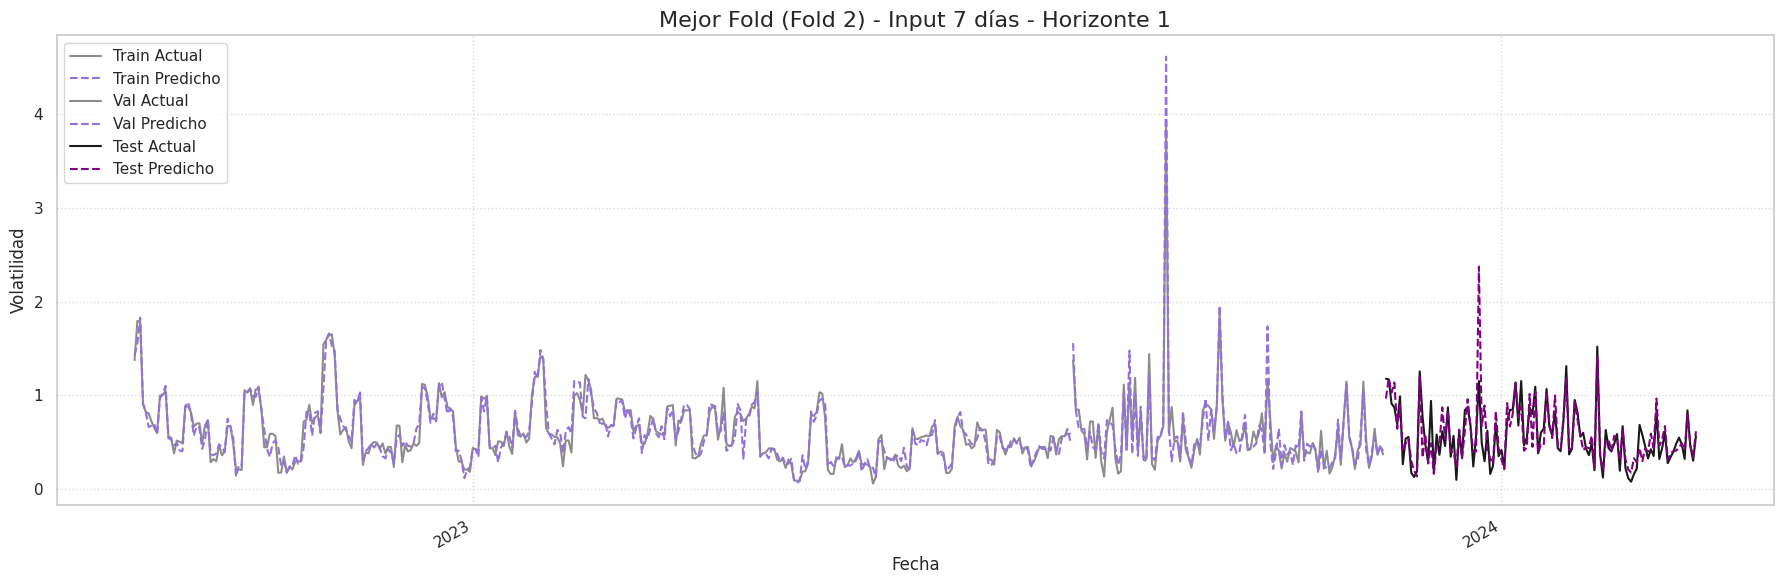

  ✓ Figura guardada: serie_temporal_lag7_Fold_Mediano_Fold_4.png


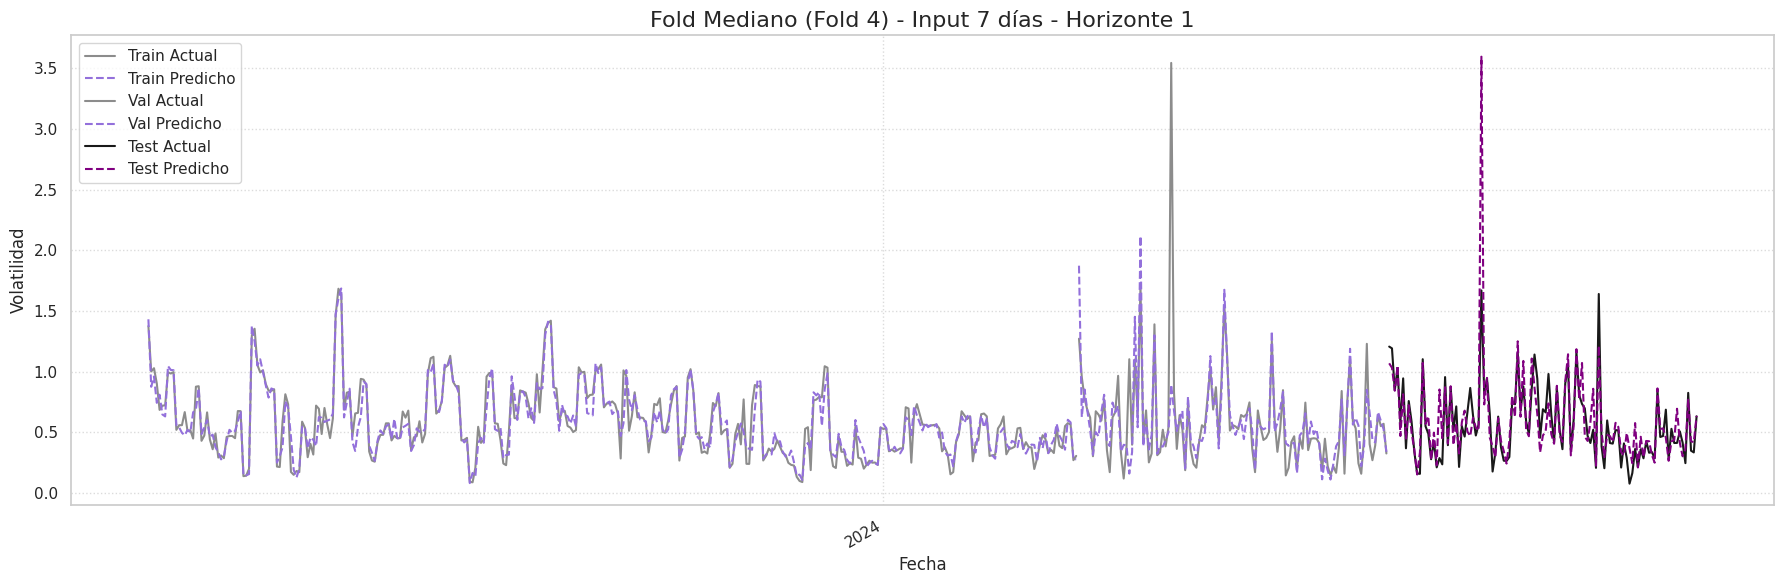

  ✓ Figura guardada: serie_temporal_lag7_Peor_Fold_Fold_5.png


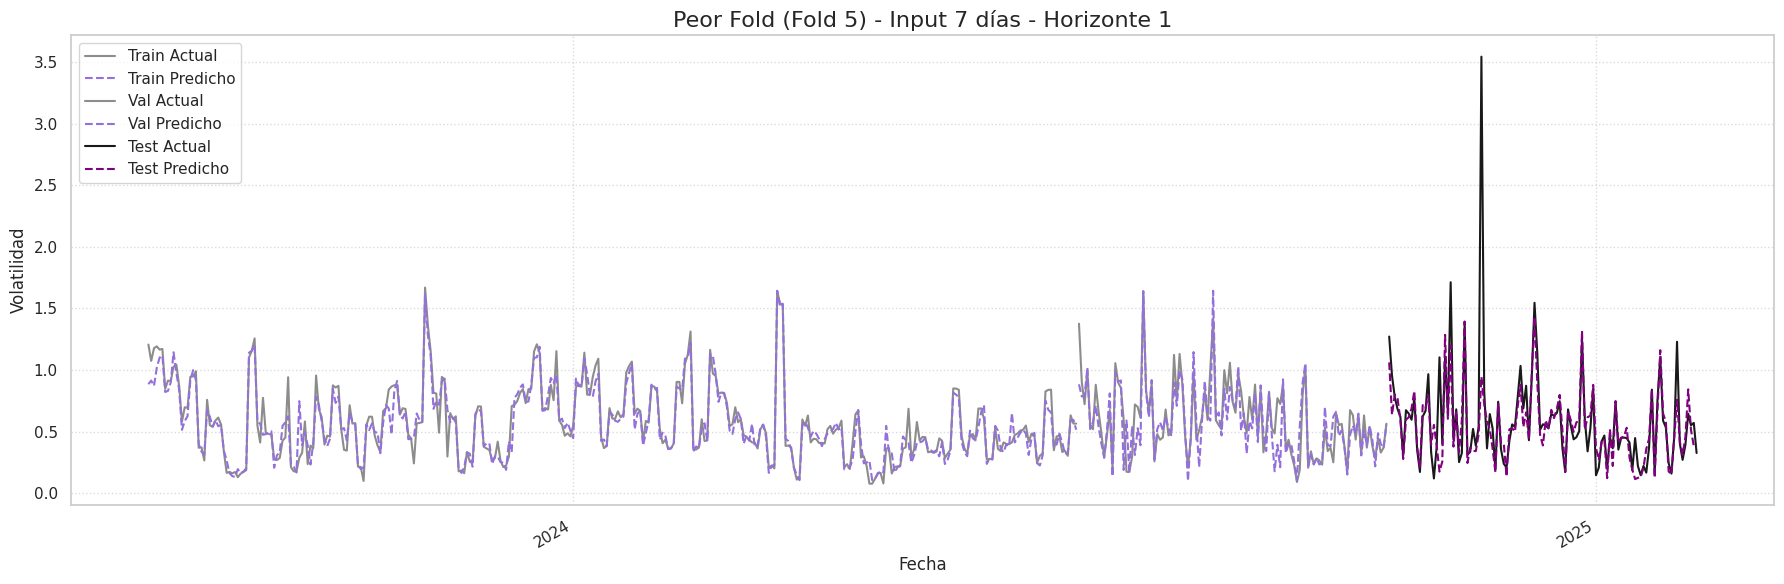


📈 Visualizando para ventana de 14 días...
  ✓ Figura guardada: serie_temporal_lag14_Mejor_Fold_Fold_2.png


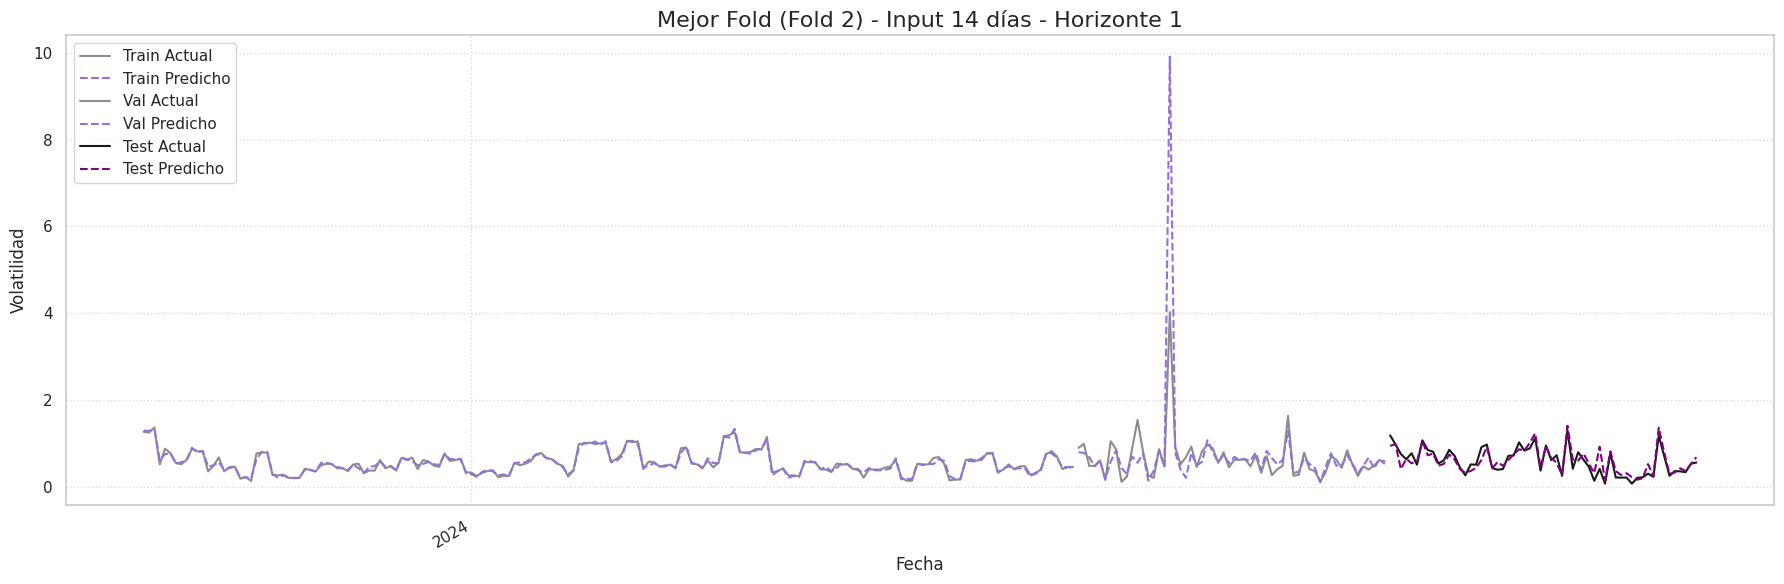

  ✓ Figura guardada: serie_temporal_lag14_Fold_Mediano_Fold_3.png


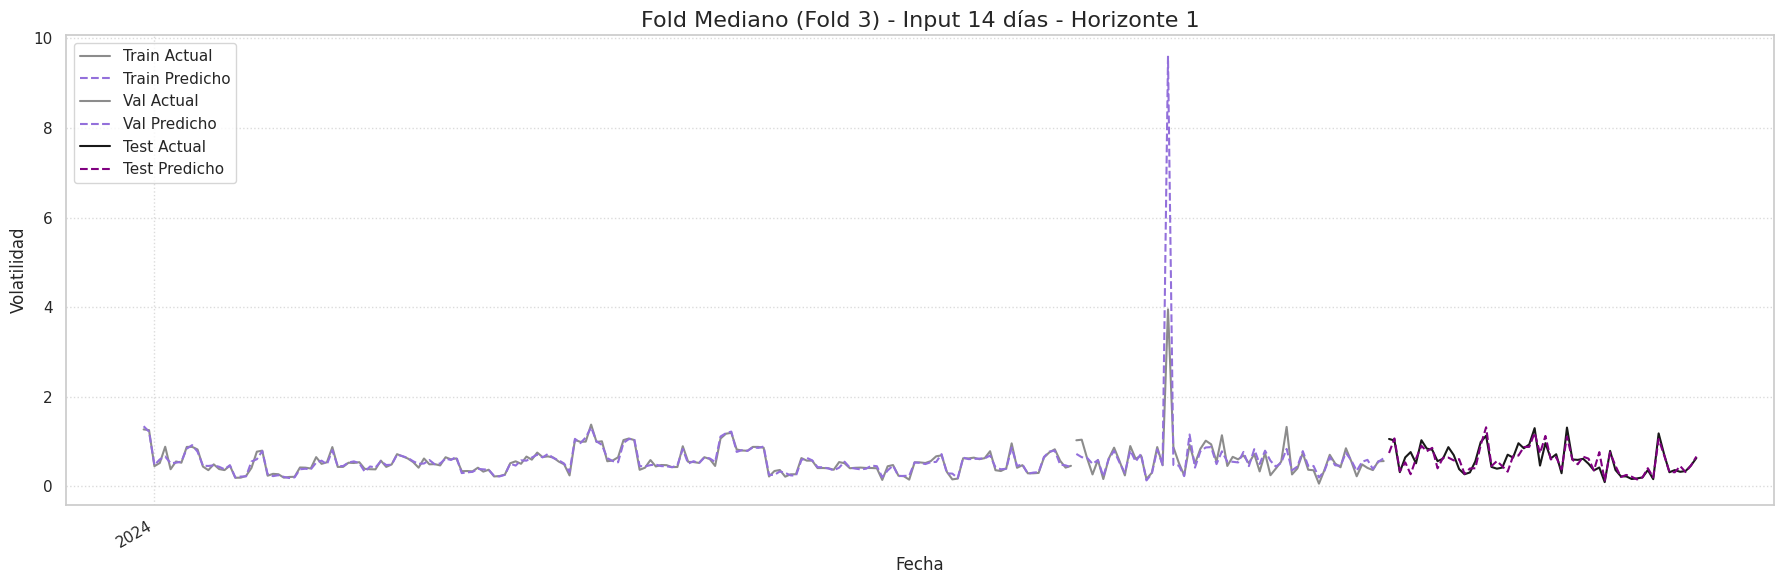

  ✓ Figura guardada: serie_temporal_lag14_Peor_Fold_Fold_5.png


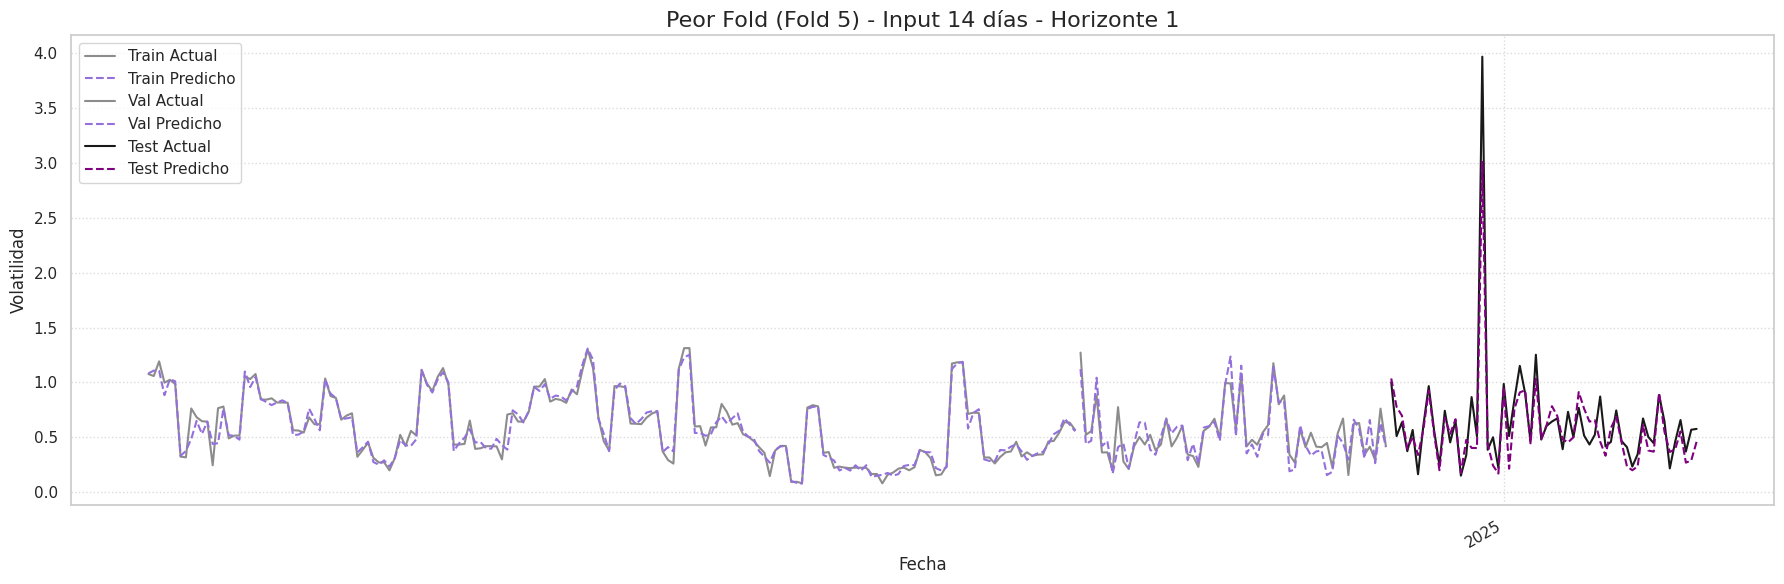


📈 Visualizando para ventana de 21 días...
  ✓ Figura guardada: serie_temporal_lag21_Mejor_Fold_Fold_5.png


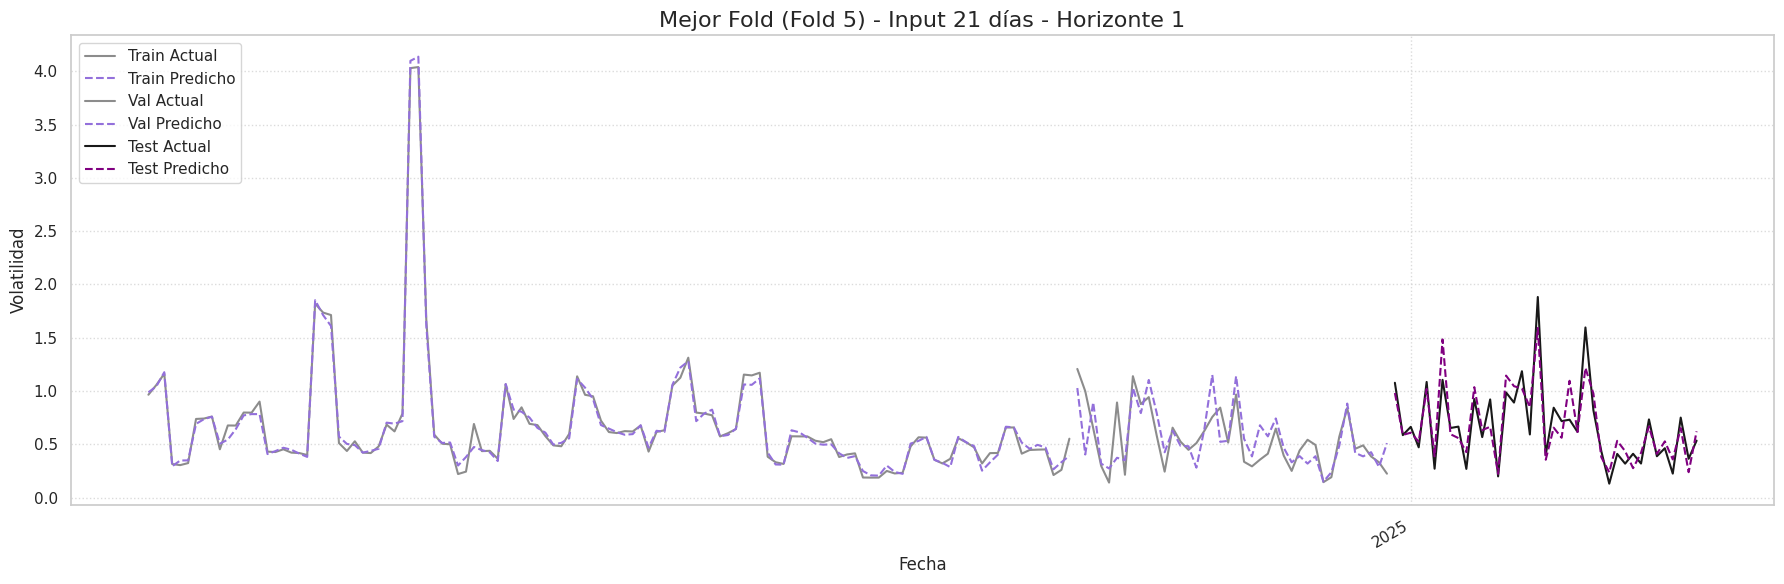

  ✓ Figura guardada: serie_temporal_lag21_Fold_Mediano_Fold_4.png


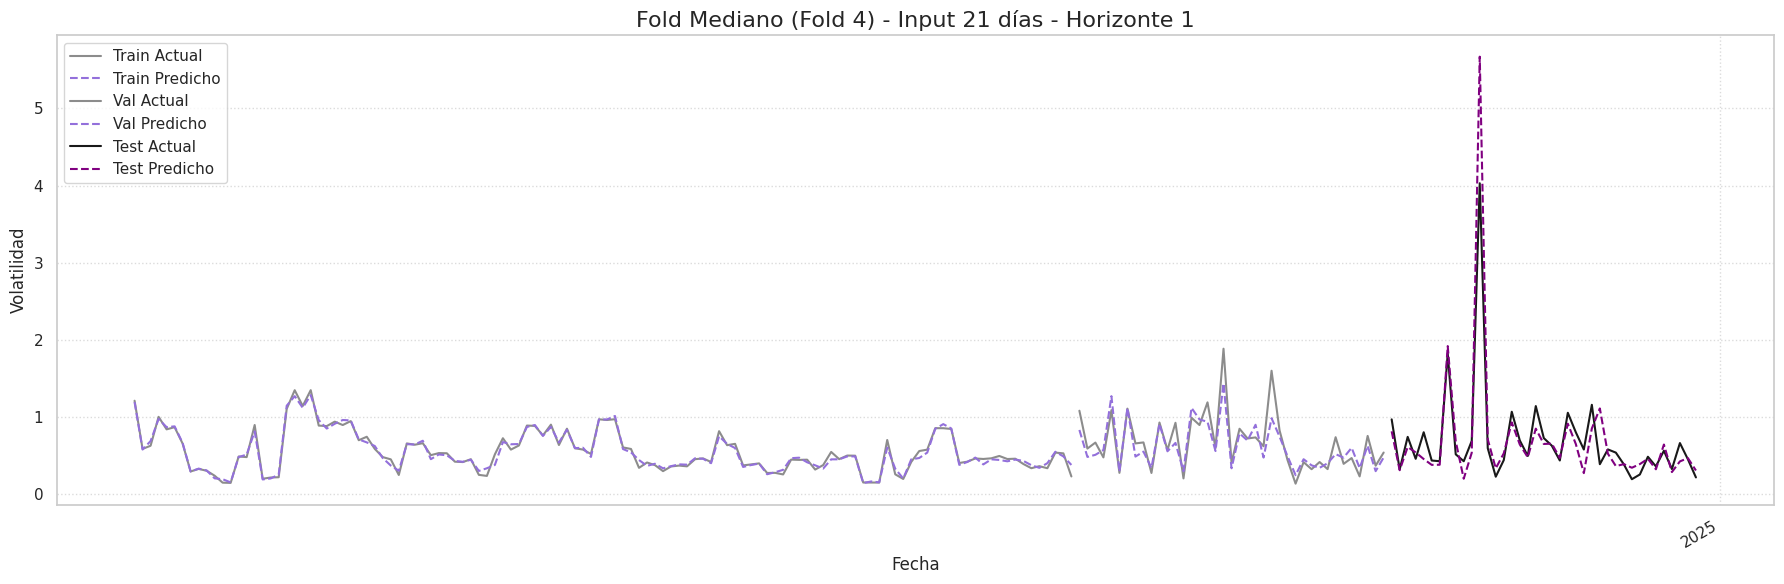

  ✓ Figura guardada: serie_temporal_lag21_Peor_Fold_Fold_3.png


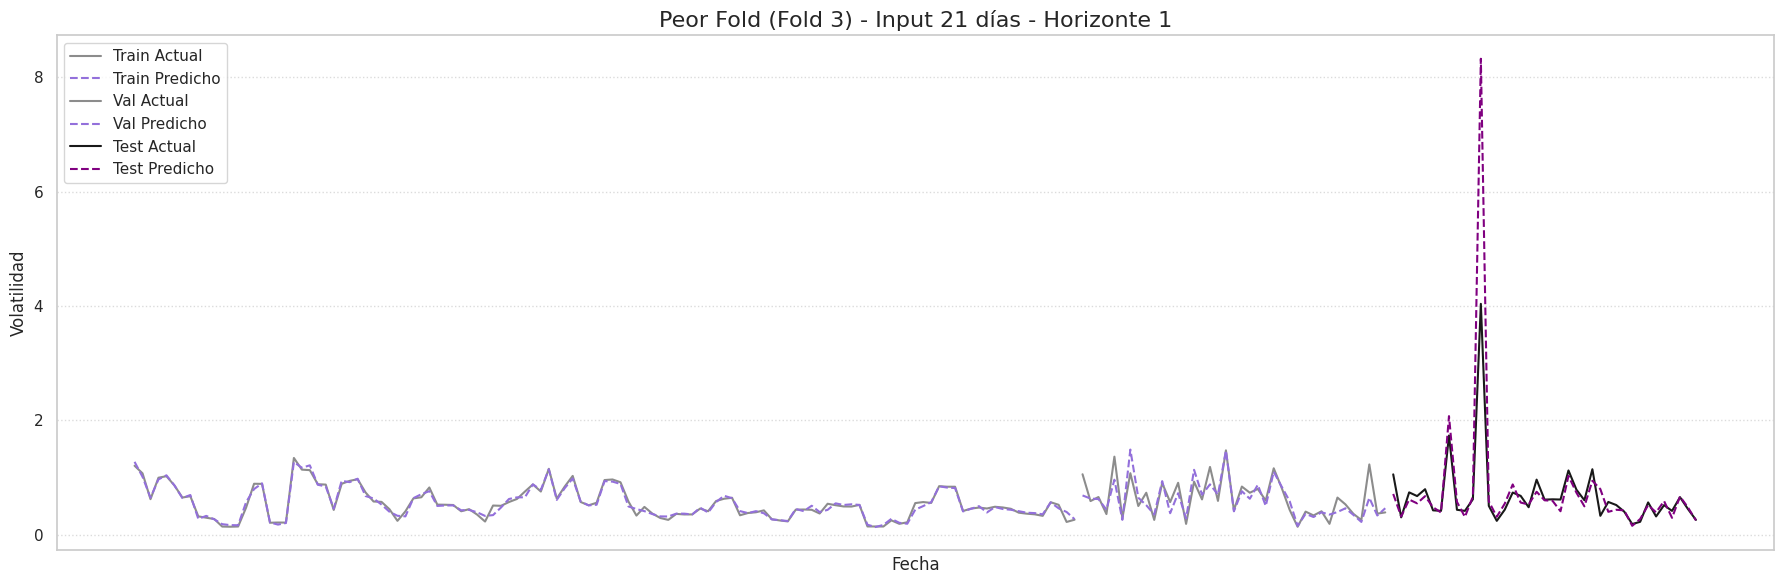


📈 Visualizando para ventana de 28 días...
  ✓ Figura guardada: serie_temporal_lag28_Mejor_Fold_Fold_5.png


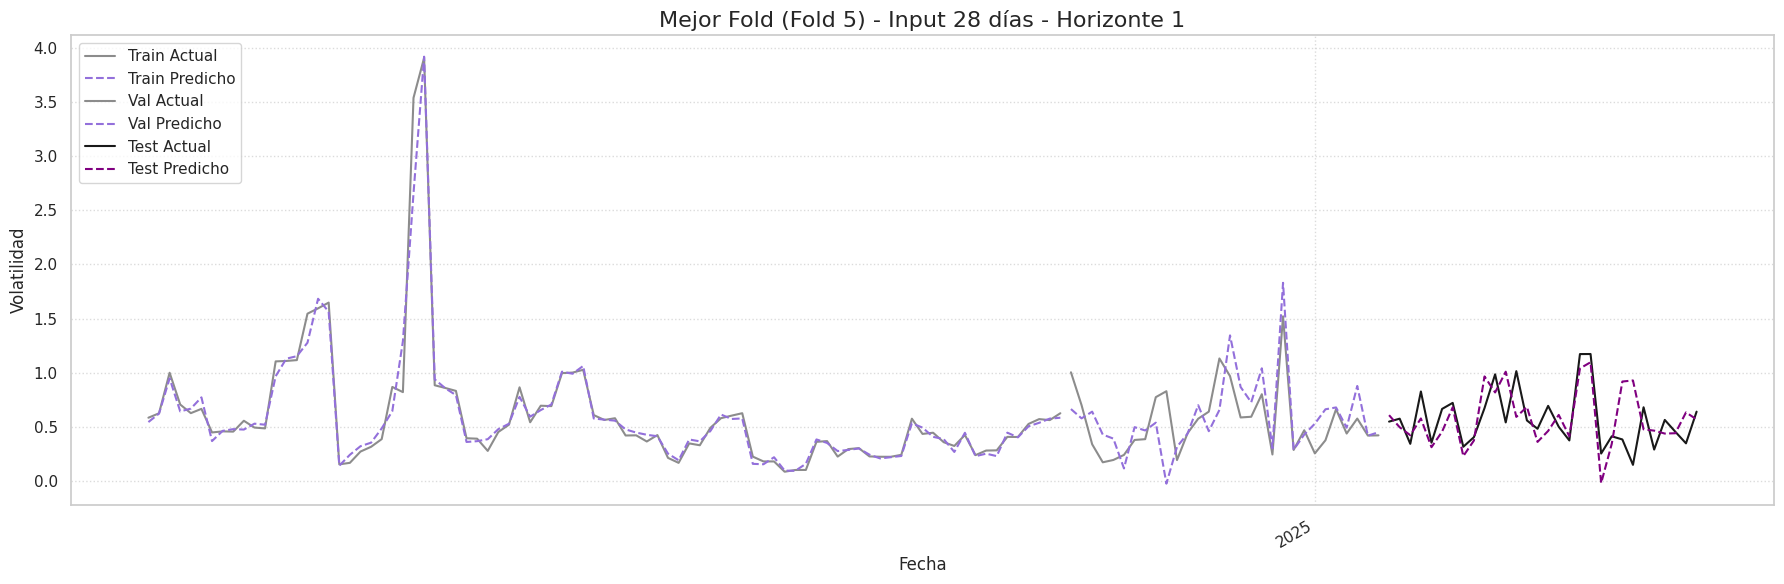

  ✓ Figura guardada: serie_temporal_lag28_Fold_Mediano_Fold_2.png


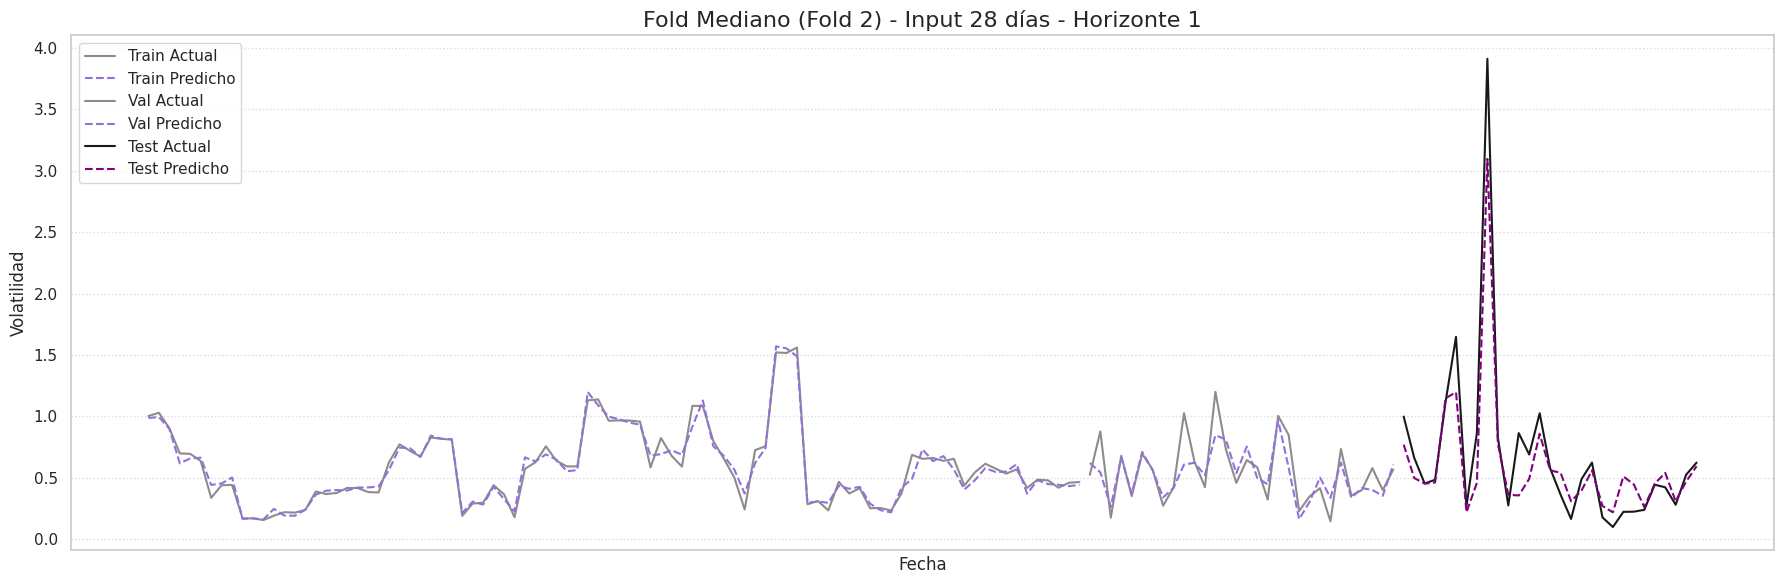

  ✓ Figura guardada: serie_temporal_lag28_Peor_Fold_Fold_3.png


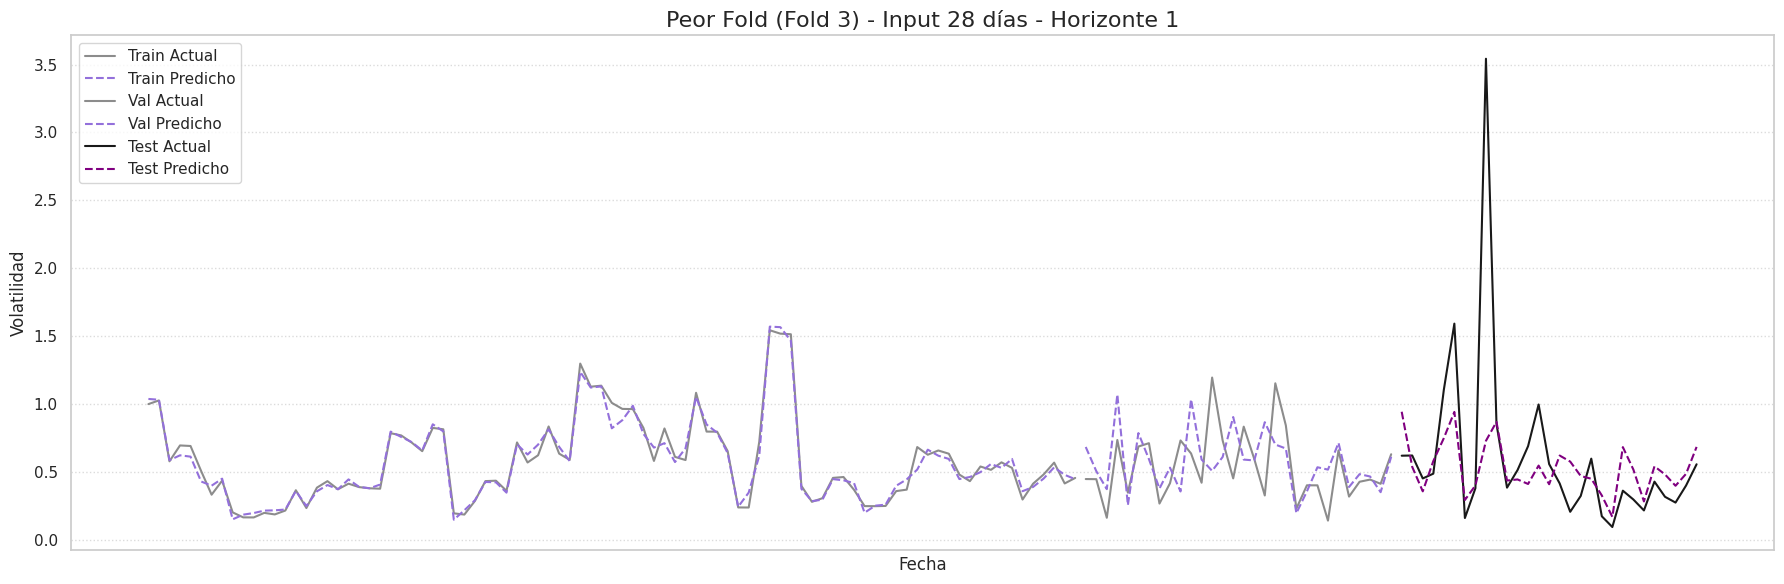


--- Generando Gráficas de Resumen de Métrica RMSE ---
✓ Figura 'RMSE por Fold' guardada.


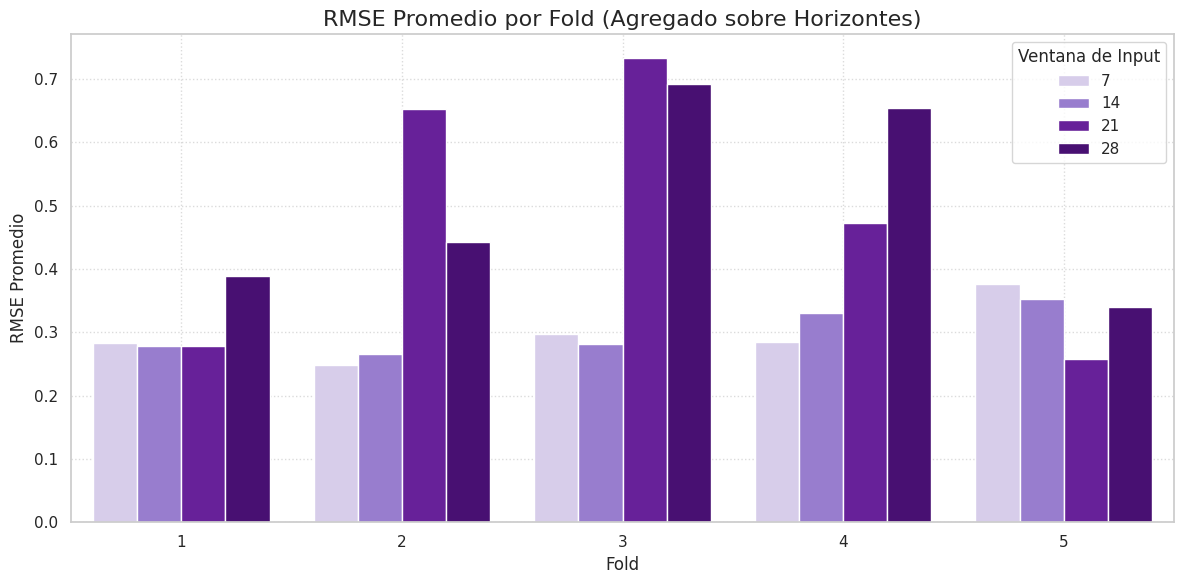

✓ Figura 'RMSE por Horizonte' guardada.


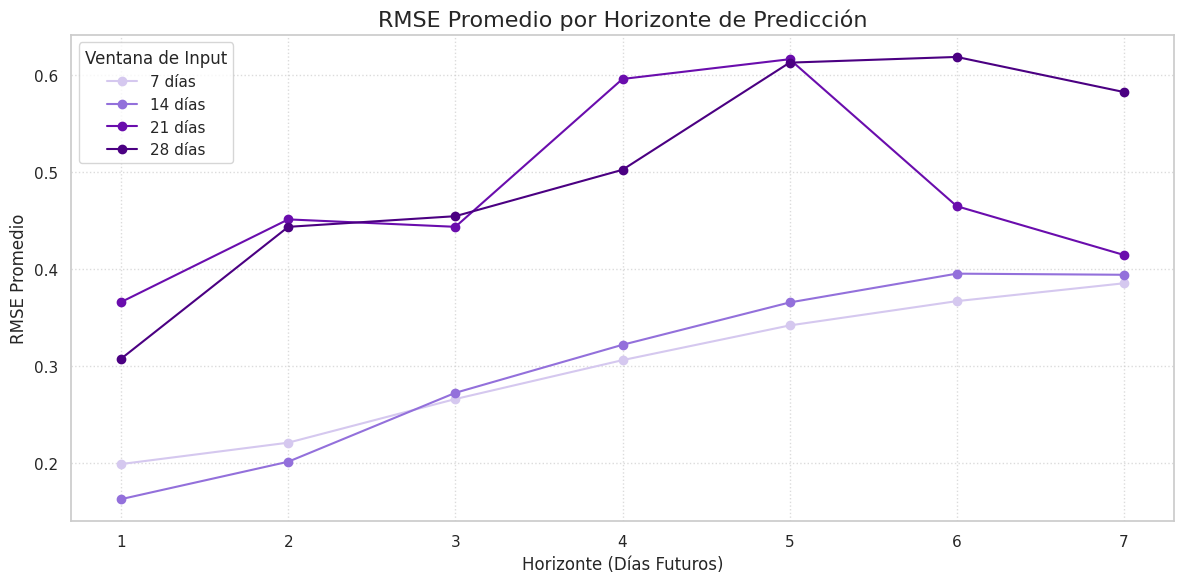


Proceso de visualización completado.


In [57]:
visualizar_experimento(results_all, results_df, LAGS_LIST, N_STEPS_FORECAST)

## Conclusión General y Síntesis de Gráficos de Rendimiento

El análisis conjunto de los gráficos de **RMSE** y de las **series temporales de predicción** ofrece una visión integral del rendimiento de los modelos.  
La evidencia visual respalda las métricas cuantitativas y explica las causas del éxito o fracaso de cada estrategia de lag.



### 1. Éxito de los Lags Cortos (7 y 14 días)
- **Evidencia Cuantitativa**:  
  - Los gráficos de RMSE muestran un error promedio más bajo y mayor estabilidad entre folds.  
- **Evidencia Cualitativa**:  
  - Las predicciones siguen de cerca la dinámica real de la volatilidad, capturando tanto la tendencia general como la magnitud y el momento de los picos.  
  - Incluso en sus peores folds mantienen una capacidad predictiva razonable.  
  - El modelo de **7 días** destaca por su ajuste superior y mayor consistencia.



### 2. Fracaso de los Lags Largos (21 y 28 días)
- **Evidencia Cuantitativa**:  
  - Los gráficos de RMSE reflejan un error más alto y errático.  
- **Evidencia Cualitativa**:  
  - Predicciones excesivamente suavizadas y, en el peor de los casos, casi planas.  
  - Incapacidad para capturar picos de volatilidad, los eventos más relevantes del pronóstico.  
  - Alta inestabilidad entre folds, con escenarios donde el modelo falla en aprender los patrones de la serie.



### 3. Síntesis: La Relevancia Temporal
- Los gráficos cuantitativos y visuales convergen en un mismo principio: el balance entre **señal** y **ruido**.  
- El modelo de **7 días** sobresale porque aprovecha datos recientes, donde la señal es fuerte y relevante.  
- Al ampliar la ventana a **21 y 28 días**, se introduce demasiado ruido histórico, lo que lleva al modelo a promediar y perder capacidad de reacción a los cambios de alta frecuencia.  



# **Diagnóstico de residuos**

In [58]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljungbox_results = []

for lag, residuals in residuals_dict.items():
    for h in range(residuals.shape[1]):
        res_h = residuals[:, h]
        try:
            if len(res_h) < 30:
                raise ValueError("Serie demasiado corta para Ljung-Box")
            lb_test = acorr_ljungbox(res_h, lags=[10], return_df=True)
            p_value = lb_test['lb_pvalue'].iloc[0]
            ljungbox_results.append({
                "Lag": lag,
                "Horizonte": h + 1,
                "Ljung-Box p-value": round(p_value, 4)
            })
        except Exception as e:
            ljungbox_results.append({
                "Lag": lag,
                "Horizonte": h + 1,
                "Ljung-Box p-value": f"Error: {str(e)}"
            })

# Convertir a tabla pivote para visualización
ljungbox_df = pd.DataFrame(ljungbox_results)
display(ljungbox_df.pivot(index="Lag", columns="Horizonte", values="Ljung-Box p-value"))



Horizonte,1,2,3,4,5,6,7
Lag,,,,,,,
7,0.0738,0.3954,0.1661,0.0695,0.1527,0.2935,0.6222
14,0.0017,0.6206,0.8032,0.8638,0.9267,0.6197,0.6958
21,0.8826,0.6804,0.0638,0.1366,0.0850,0.1023,0.0233
28,0.8081,0.6616,0.7918,0.7214,0.2360,0.0286,0.1434


El propósito de la prueba de **Ljung-Box** en este contexto es verificar si los errores (residuos) de los modelos son aleatorios o si aún contienen patrones de autocorrelación no capturados. Un modelo robusto debería dejar residuos que se asemejen al **ruido blanco**, es decir, sin autocorrelación significativa.


## Análisis por Modelo

###  Modelo de 7 Días — Rendimiento Superior 
- **Resultado:** p-valores > 0.05 en todos los horizontes (H1–H7).  
- **Conclusión:** Los residuos son indistinguibles del ruido blanco.  
  → Ha capturado eficazmente la estructura temporal de la volatilidad.


###  Modelo de 14 Días — Problemático en el Corto Plazo
- **Resultado:** p-valor = 0.0017 en H1 (muy bajo y significativo).  
- **Conclusión:** Débil para el horizonte más crítico (1 día).  
  → Aunque mejora en H2–H7, omite información predecible en el corto plazo.


###  Modelos de 21 y 28 Días — Débiles en el Largo Plazo
- **Resultado:**  
  - Modelo 21 días falla en H7 (p-valor = 0.0233).  
  - Modelo 28 días falla en H6 (p-valor = 0.0286).  
- **Conclusión:** Funcionan razonablemente en horizontes cortos, pero pierden eficacia en horizontes largos.  
  → Dejan patrones sin explicar en los residuos.


## Síntesis General
- El modelo de **7 días** es el más **preciso, estable y estadísticamente robusto**.  
- Supera a los demás porque sus residuos pasan la prueba de Ljung-Box en todos los horizontes.  
- Los modelos de **14, 21 y 28 días** presentan **fallos estructurales**:  
  - El de 14 días falla en el corto plazo.  
  - Los de 21 y 28 días fallan en los horizontes largos.  
 
El modelo de **7 días** no solo ofrece mejor precisión y estabilidad (según RMSE y gráficos), sino que también garantiza la robustez estadística de sus predicciones. Es la opción óptima para pronósticos de volatilidad a corto plazo.
